In [38]:
import torch

# Sen2Venus pretraining dataloading

## Setup config

In [2]:
from dinov3.configs.config import setup_job, setup_config, DinoV3SetupArgs

setup_job()

I20251105 15:05:00 1237037 dinov3 torch_distributed_wrapper.py:255] PyTorch distributed environment: manual job using 127.0.0.1:52261 (rank=0, world size=1)


[rank0]:[W1105 15:05:01.820715232 ProcessGroupNCCL.cpp:4561] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. Specify device_ids in barrier() to force use of a particular device, or call init_process_group() with a device_id.


I20251105 15:05:01 1237037 dinov3 config.py:209] git:
  sha: 646d3b72a9a107ec39a6809f9143ad13d478d76a, status: has uncommited changes, branch: main

I20251105 15:05:01 1237037 dinov3 config.py:213] conda env name: dinov3
I20251105 15:05:01 1237037 dinov3 config.py:214] conda env path: /home/admin/anaconda3/envs/dinov3
I20251105 15:05:01 1237037 dinov3 config.py:215] python path: ['/home/admin/john/SR4Seg', '/home/admin/john/SR4Seg/dinov3', '/home/admin/john/SR4Seg/ijepa', '/home/admin/anaconda3/envs/dinov3/lib/python311.zip', '/home/admin/anaconda3/envs/dinov3/lib/python3.11', '/home/admin/anaconda3/envs/dinov3/lib/python3.11/lib-dynload', '', '/home/admin/anaconda3/envs/dinov3/lib/python3.11/site-packages']


In [3]:
args = DinoV3SetupArgs(config_file='/home/admin/john/SR4Seg/dinov3/dinov3/configs/train/dinov3_vitsmall16_pretrain_sr_gram_anchor.yaml')

cfg = setup_config(args, strict_cfg=False)
cfg.batch_size_per_gpu = 1

I20251105 15:05:01 1237037 dinov3 config.py:100] config_file: /home/admin/john/SR4Seg/dinov3/dinov3/configs/train/dinov3_vitsmall16_pretrain_sr_gram_anchor.yaml
opts: []
output_dir: 
pretrained_weights: None
shard_unsharded_model: False
I20251105 15:05:01 1237037 dinov3 config.py:58] MODEL:
  META_ARCHITECTURE: SSLMetaArchHRLR
  DEVICE: cuda
  WEIGHTS: ''
  DTYPE: float32
compute_precision:
  param_dtype: bf16
  reduce_dtype: fp32
  sharding_strategy: SHARD_GRAD_OP
dino:
  loss_weight: 1.0
  global_ignore_diagonal: true
  head_n_prototypes: 4096
  head_bottleneck_dim: 512
  head_norm_last_layer: false
  head_nlayers: 2
  head_hidden_dim: 2048
  koleo_loss_weight: 0.1
  koleo_loss_distributed: false
  koleo_topk: 1
  koleo_distributed_replicas: 0
  koleo_distributed_loss_group_size: null
  koleo_distributed_loss_group_data: true
  force_weight_norm: false
  reweight_dino_local_loss: true
  local_loss_weight_schedule:
    start: 1
    peak: 1
    end: 0.5
    warmup_epochs: 80
    cosine

## Setup Model

In [4]:
from dinov3.train.multidist_meta_arch import MultiDistillationMetaArch
from dinov3.train.ssl_meta_arch import SSLMetaArch
from dinov3.train.ssl_meta_arch_hrlr import SSLMetaArchHRLR

meta_arch = {
    "SSLMetaArch": SSLMetaArch,
    "SSLMetaArchHRLR": SSLMetaArchHRLR,
    "MultiDistillationMetaArch": MultiDistillationMetaArch,
}.get(cfg.MODEL.META_ARCHITECTURE, None)

with torch.device("meta"):
    model = meta_arch(cfg)
model.prepare_for_distributed_training()

I20251105 15:05:02 1237037 dinov3 vision_transformer.py:116] using base=100 for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:117] using min_period=None for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:118] using max_period=None for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:119] using normalize_coords=separate for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:120] using shift_coords=None for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:121] using rescale_coords=2 for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:122] using jitter_coords=None for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:123] using dtype=bf16 for rope new
I20251105 15:05:02 1237037 dinov3 vision_transformer.py:137] using swiglu64 layer as FFN
I20251105 15:05:02 1237037 dinov3 __init__.py:25] fp8 matmuls: ON
I20251105 15:05:03 1237037 dinov3 vision_transformer.py:116] using base=1

## Setup dataloader

In [5]:
from dinov3.train.train import build_multi_resolution_data_loader_from_cfg, build_data_loader_from_cfg

data_loader = build_multi_resolution_data_loader_from_cfg(
    cfg=cfg,
    model=model,
    start_iter=1,
)

data_loader = build_data_loader_from_cfg(
    cfg=cfg,
    model=model,
    start_iter=1,
)

I20251105 15:05:04 1237037 dinov3 augmentations.py:272] ###################################
I20251105 15:05:04 1237037 dinov3 augmentations.py:273] Using HR/LR multispectral data augmentation parameters:
I20251105 15:05:04 1237037 dinov3 augmentations.py:274] global_crops_scale: [0.32, 1.0]
I20251105 15:05:04 1237037 dinov3 augmentations.py:275] local_crops_scale: [0.05, 0.32]
I20251105 15:05:04 1237037 dinov3 augmentations.py:276] local_crops_number: 8
I20251105 15:05:04 1237037 dinov3 augmentations.py:277] global_crops_size: 256
I20251105 15:05:04 1237037 dinov3 augmentations.py:278] local_crops_size: 112
I20251105 15:05:04 1237037 dinov3 augmentations.py:279] gram_crops_size: 512
I20251105 15:05:04 1237037 dinov3 augmentations.py:280] gram_teacher_no_distortions: False
I20251105 15:05:04 1237037 dinov3 augmentations.py:281] local_crops_subset_of_global_crops: False
I20251105 15:05:04 1237037 dinov3 augmentations.py:282] patch_size if local_crops_subset_of_global_crops: 16
I20251105 

In [6]:
for data in data_loader:
    inputs = data
    break

In [7]:
inputs.keys()

dict_keys(['collated_global_crops_hr', 'collated_global_crops_lr', 'collated_local_crops_hr', 'collated_local_crops_lr', 'collated_masks', 'mask_indices_list', 'masks_weight', 'upperbound', 'n_masked_patches', 'collated_gram_teacher_crops_hr', 'collated_gram_teacher_crops_lr'])

In [8]:
inputs['collated_global_crops_lr'].unique()[:50]

tensor([-2.4688, -2.4531, -2.4375, -2.4219, -2.4062, -2.3906, -2.3750, -2.3594,
        -2.3438, -2.3281, -2.3125, -2.2969, -2.2812, -2.2656, -2.2500, -2.2344,
        -2.2188, -2.2031, -2.1875, -2.1719, -2.1562, -2.1406, -2.1250, -2.1094,
        -2.0938, -2.0781, -2.0625, -2.0469, -2.0312, -2.0156, -2.0000, -1.9922,
        -1.9844, -1.9766, -1.9688, -1.9609, -1.9531, -1.9453, -1.9375, -1.9297,
        -1.9219, -1.9141, -1.9062, -1.8984, -1.8906, -1.8828, -1.8750, -1.8672,
        -1.8594, -1.8516], dtype=torch.bfloat16)

In [9]:
cfg.multidistillation

{'enabled': False}

In [10]:
global_crops_hr = inputs['collated_global_crops_hr']
global_crops_lr = inputs['collated_global_crops_lr']
global_crops_hr.shape

torch.Size([2, 4, 256, 256])

In [11]:
global_crops_hr.unique()

tensor([-2.4531, -2.4375, -2.4219,  ...,  2.6094,  2.6250,  2.6406],
       dtype=torch.bfloat16)

In [12]:
import numpy as np

def reverse_norm(img_hr, img_lr):
    std_hr = torch.tensor(cfg.crops.std_hr).reshape(-1, 1, 1)
    mean_hr = torch.tensor(cfg.crops.mean_hr).reshape(-1, 1, 1)
    std_lr = torch.tensor(cfg.crops.std_lr).reshape(-1, 1, 1)
    mean_lr = torch.tensor(cfg.crops.mean_lr).reshape(-1, 1, 1)
    
    img_hr = img_hr * std_hr + mean_hr
    img_lr = img_lr * std_lr + mean_lr

    rgb_hr = img_hr[[2, 1, 0]]
    rgb_lr = img_lr[[2, 1, 0]]

    rgb_hr = (rgb_hr - rgb_hr.min()) / (rgb_hr.max() - rgb_hr.min())
    rgb_lr = (rgb_lr - rgb_lr.min()) / (rgb_lr.max() - rgb_lr.min())

    rgb_hr = np.array(rgb_hr * 255, dtype="uint8")
    rgb_lr = np.array(rgb_lr * 255, dtype="uint8")

    rgb_hr = np.transpose(rgb_hr, (1, 2, 0))
    rgb_lr = np.transpose(rgb_lr, (1, 2, 0))

    return rgb_hr, rgb_lr

In [13]:
rgb_hr, rgb_lr = reverse_norm(inputs['collated_local_crops_hr'][0], inputs['collated_local_crops_lr'][0])

W20251105 15:05:09 1237037 py.warnings warnings.py:110] /tmp/ipykernel_1237037/3018867133.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rgb_hr = np.array(rgb_hr * 255, dtype="uint8")

W20251105 15:05:09 1237037 py.warnings warnings.py:110] /tmp/ipykernel_1237037/3018867133.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rgb_lr = np.array(rgb_lr * 255, dtype="uint8")



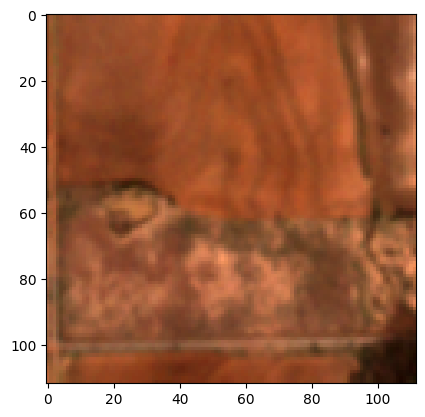

In [14]:
import matplotlib.pyplot as plt

plt.imshow(rgb_hr)

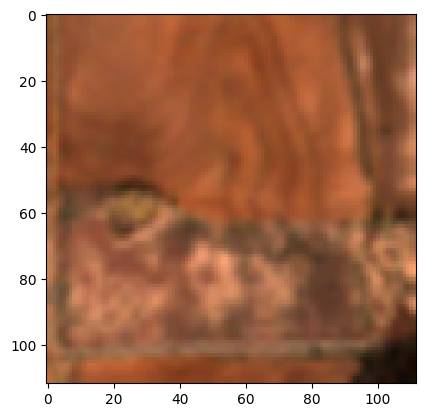

In [15]:
plt.imshow(rgb_lr)

# MADOS eval dataloading

## Load config

In [1]:
from omegaconf import OmegaConf
from dinov3.eval.segmentation.config import SegmentationConfig

base_config = OmegaConf.load("/home/admin/john/SR4Seg/dinov3/dinov3/eval/segmentation/configs/config-mados_linear_probing.yaml")
structured_config = OmegaConf.structured(SegmentationConfig)
config: SegmentationConfig = OmegaConf.to_object(
    OmegaConf.merge(
        structured_config,
        base_config,
    )
)
config

SegmentationConfig(model=ModelConfig(config_file='/home/admin/john/SR4Seg/dinov3/dinov3/configs/train/dinov3_vitsmall16_pretrain_sr.yaml', pretrained_weights='/home/admin/john/SR4Seg/dinov3/logs/fixed_norm/eval/training_37499/sharded_teacher_checkpoint', dino_hub=None), bs=128, n_gpus=1, num_workers=3, model_dtype=<ModelDtype.FLOAT32: 'float32'>, seed=100, datasets=DatasetConfig(root='/home/admin/AGML_ResearchGroup/SuperResolution/mados/', train='MADOS:split=train', val='MADOS:split=val'), metric_to_save='mIoU', decoder_head=DecoderConfig(type='linear', backbone_out_layers=<BackboneLayersSet.LAST: 'LAST'>, use_batchnorm=True, use_cls_token=False, use_backbone_norm=True, num_classes=15, hidden_dim=2048), scheduler=SchedulerConfig(type='WarmupOneCycleLR', total_iter=20000, constructor_kwargs={'warmup_iters': 1000, 'warmup_ratio': 1e-06, 'final_div_factor': inf, 'pct_start': 0, 'anneal_strategy': 'cos', 'use_beta1': False, 'update_momentum': False}), optimizer=OptimizerConfig(lr=1e-05, be

## Load model

In [2]:
from dinov3.eval.setup import load_model_and_context
from dinov3.configs import exit_job, setup_job

setup_job(
    output_dir=config.output_dir,
    distributed_enabled=False,
    logging_enabled=True,
    seed=0,
    restrict_print_to_main_process=True,
    distributed_timeout=None,
)
backbone, _ = load_model_and_context(config.model, output_dir=config.output_dir)

I20251107 16:15:57 1866492 dinov3 config.py:209] git:
  sha: a84024abde6af45b58682b4706a21e71783af606, status: has uncommited changes, branch: main

I20251107 16:15:57 1866492 dinov3 config.py:213] conda env name: dinov3
I20251107 16:15:57 1866492 dinov3 config.py:214] conda env path: /home/admin/anaconda3/envs/dinov3
I20251107 16:15:57 1866492 dinov3 config.py:215] python path: ['/home/admin/john/SR4Seg', '/home/admin/john/SR4Seg/dinov3', '/home/admin/john/SR4Seg/ijepa', '/home/admin/anaconda3/envs/dinov3/lib/python311.zip', '/home/admin/anaconda3/envs/dinov3/lib/python3.11', '/home/admin/anaconda3/envs/dinov3/lib/python3.11/lib-dynload', '', '/home/admin/anaconda3/envs/dinov3/lib/python3.11/site-packages', '/home/admin/anaconda3/envs/dinov3/lib/python3.11/site-packages/setuptools/_vendor', '/tmp/tmpigeghie5']
I20251107 16:15:57 1866492 dinov3 config.py:100] config_file: /home/admin/john/SR4Seg/dinov3/dinov3/configs/train/dinov3_vitsmall16_pretrain_sr.yaml
opts: []
output_dir: /home/a

AssertionError: Setup distributed to get global size !

In [4]:
from functools import partial
from dinov3.eval.segmentation.transforms import make_segmentation_eval_transforms, make_segmentation_train_transforms
from dinov3.data import DatasetWithEnumeratedTargets, SamplerType, make_data_loader, make_dataset
import dinov3.distributed as distributed
from dinov3.eval.segmentation.train import worker_init_fn, InfiniteDataloader

global_device = distributed.get_rank()

train_transforms = make_segmentation_train_transforms(
    img_size=config.transforms.train.img_size,
    random_img_size_ratio_range=config.transforms.train.random_img_size_ratio_range,
    crop_size=config.transforms.train.crop_size,
    flip_prob=config.transforms.train.flip_prob,
    reduce_zero_label=config.eval.reduce_zero_label,
)
val_transforms = make_segmentation_eval_transforms(
    img_size=config.transforms.eval.img_size,
    inference_mode=config.eval.mode,
)

train_dataset = DatasetWithEnumeratedTargets(
    make_dataset(
        dataset_str=f"{config.datasets.train}:root={config.datasets.root}",
        transforms=train_transforms,
    )
)
train_sampler_type = None
if distributed.is_enabled():
    train_sampler_type = SamplerType.DISTRIBUTED
init_fn = partial(
    worker_init_fn, num_workers=config.num_workers, rank=global_device, seed=config.seed + global_device
)
train_dataloader = InfiniteDataloader(
    make_data_loader(
        dataset=train_dataset,
        batch_size=config.bs,
        num_workers=config.num_workers,
        sampler_type=train_sampler_type,
        shuffle=True,
        persistent_workers=False,
        worker_init_fn=init_fn,
    )
)

val_dataset = DatasetWithEnumeratedTargets(
    make_dataset(
        dataset_str=f"{config.datasets.val}:root={config.datasets.root}",
        transforms=val_transforms,
    )
)
val_sampler_type = None
if distributed.is_enabled():
    val_sampler_type = SamplerType.DISTRIBUTED
val_dataloader = make_data_loader(
    dataset=val_dataset,
    batch_size=1,
    num_workers=config.num_workers,
    sampler_type=val_sampler_type,
    drop_last=False,
    shuffle=False,
    persistent_workers=True,
)

I20251107 16:16:09 1866492 dinov3 loaders.py:116] using dataset: "MADOS:split=train:root=/home/admin/AGML_ResearchGroup/SuperResolution/mados/"
I20251107 16:16:09 1866492 dinov3 loaders.py:121] # of dataset samples: 2,657
I20251107 16:16:09 1866492 dinov3 loaders.py:192] sampler: none
I20251107 16:16:09 1866492 dinov3 loaders.py:241] using PyTorch data loader
I20251107 16:16:09 1866492 dinov3 loaders.py:255] # of batches: 20
I20251107 16:16:09 1866492 dinov3 loaders.py:116] using dataset: "MADOS:split=val:root=/home/admin/AGML_ResearchGroup/SuperResolution/mados/"
I20251107 16:16:09 1866492 dinov3 loaders.py:121] # of dataset samples: 1,186
I20251107 16:16:09 1866492 dinov3 loaders.py:192] sampler: none
I20251107 16:16:09 1866492 dinov3 loaders.py:241] using PyTorch data loader
I20251107 16:16:09 1866492 dinov3 loaders.py:255] # of batches: 1,186


In [5]:
for b in train_dataloader:
    batch_img, (_, gt) = b
    break

In [6]:
gt.unique()

tensor([  0,   3,   4,   5,   6,   9,  10,  11,  12, 255])

In [7]:
import os
import json
import numpy as np

norm_stats_path = os.path.join(config.datasets.root, 'NORM_CONFIG.json')

with open(norm_stats_path, "r") as f:
    norm_config = json.load(f)

, norm_config['std']
# torch.tensor(norm_config['mean'])[[1, 2, 3, 6]]

"norm_config['std']"

In [13]:
import torch

def prep_for_vis(img):
    std = torch.tensor(norm_config['std'])[[1, 2, 3, 6]].reshape(-1, 1, 1)
    mean = torch.tensor(norm_config['mean'])[[1, 2, 3, 6]].reshape(-1, 1, 1)
    
    img = img * std + mean
    
    rgb = img[[2, 1, 0]]

    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    
    rgb = np.array(rgb * 255, dtype="uint8")

    rgb = np.transpose(rgb, (1, 2, 0))

    return rgb

In [14]:

img = batch_img[0]
img.unique(), mask

(tensor([-0.4002, -0.3903, -0.3901,  ...,  1.0481,  1.0582,  1.0793]),
 tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ...,   5,   5,   5],
          [255, 255, 255,  ...,   5,   5,   5],
          [255, 255, 255,  ...,   5,   5,   5]]]))

In [30]:
sample_idx = 100

W20251107 16:18:29 1866492 py.warnings warnings.py:110] /tmp/ipykernel_1866492/3269529007.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rgb = np.array(rgb * 255, dtype="uint8")



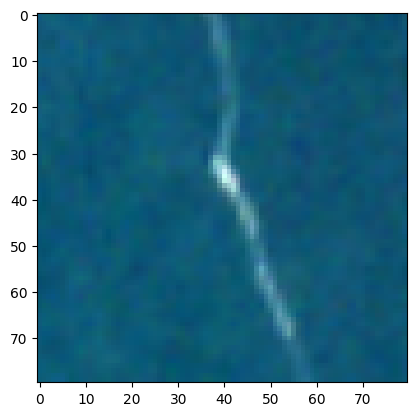

In [31]:
import matplotlib.pyplot as plt

img = batch_img[sample_idx]
img_vis = prep_for_vis(img)
plt.imshow(img_vis)

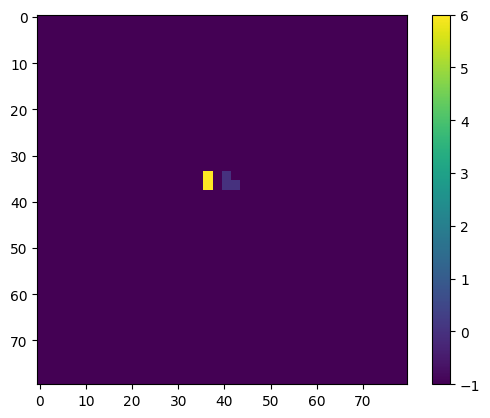

In [32]:
mask = gt[sample_idx]
mask = torch.where(mask == 255, -1, mask)
mask = np.transpose(mask, (1, 2, 0))
im = plt.imshow(mask)

plt.colorbar(im)

In [112]:
mask.unique()

tensor([ -1, 255])